In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import nltk
import pickle
from tqdm import tqdm

from collections import Counter
import pandas as pd

custom_dataset_path = "/content/drive/MyDrive/custom_captions_dataset/"

class Vocabulary(object):
    def __init__(self,
                 vocab_threshold,
                 vocab_file='./vocab.pkl',
                 start_word="<start>",
                 end_word="<end>",
                 unk_word="<unk>",
                 data_folder='../custom_captions_dataset/',
                 vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          data_folder: Path for the folder containing the CSV files.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.data_folder = data_folder
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        counter = Counter()

        # Load the training data CSV file
        captions_df = pd.read_csv(os.path.join(self.data_folder, 'train.csv'))

        for i, caption in enumerate(captions_df['caption']):
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 1000 == 0:
              progress = i / len(captions_df)
              progress_bar_length = 20
              progress_bar = '#' * int(progress * progress_bar_length)
              remaining_spaces = ' ' * (progress_bar_length - len(progress_bar))
              print(f"[{i}/{len(captions_df)}] Tokenizing captions... [{progress_bar}{remaining_spaces}] {progress * 100:.2f}%")

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


In [4]:
import os
import pandas as pd
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, BatchSampler

custom_dataset_path = "/content/drive/MyDrive/custom_captions_dataset/"

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               data_folder='./custom_dataset'):

    assert mode in ['train', 'test', 'val'], "mode must be one of 'train', 'test', 'val."
    if not vocab_from_file: assert mode == 'train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Ensure the vocabulary file exists if vocab_from_file is True
    if vocab_from_file: assert os.path.exists(vocab_file), "vocab_file does not exist. Change vocab_from_file to False to create vocab_file."

    # Initialize the custom dataset
    vocab = None  # Initialize your Vocabulary class here if needed
    dataset = CustomCaptionDataset(transform=transform,
                                   mode=mode,
                                   batch_size=batch_size,
                                   vocab_threshold=vocab_threshold,
                                   vocab_file=vocab_file,
                                   start_word=start_word,
                                   end_word=end_word,
                                   unk_word=unk_word,
                                   data_folder=data_folder,
                                   vocab_from_file=vocab_from_file)

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = SubsetRandomSampler(indices)
        data_loader = DataLoader(dataset=dataset,
                                 num_workers=num_workers,
                                 batch_sampler=BatchSampler(sampler=initial_sampler,
                                                            batch_size=batch_size,
                                                            drop_last=False))
    else:
        # For testing mode, you might not need to sample by caption length.
        data_loader = DataLoader(dataset=dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers)

    return data_loader


class CustomCaptionDataset(Dataset):
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word,
                 end_word, unk_word, data_folder, vocab_from_file):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
                                end_word, unk_word, data_folder, vocab_from_file)
        self.img_folder = os.path.join(data_folder, mode)

        # Load captions and image paths
        self.captions_file = pd.read_csv(os.path.join(data_folder, f'{mode}.csv'))
        self.img_paths = self.captions_file['filename'].values
        self.captions = self.captions_file['caption'].values

        print('Obtaining caption lengths...')
        self.caption_lengths = [len(nltk.tokenize.word_tokenize(str(caption).lower())) for caption in tqdm(self.captions)]

    def __getitem__(self, index):
        # Load and transform the image
        img_path = os.path.join(self.img_folder, self.img_paths[index])
        image = Image.open(img_path).convert('RGB')
        orig_image = np.array(image)
        if self.transform:
            image = self.transform(image)

        # Process the caption
        caption = self.captions[index]
        # print("caption: ", caption, index)
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption_tokens = []
        caption_tokens.append(self.vocab(self.vocab.start_word))
        caption_tokens.extend([self.vocab(token) for token in tokens])
        caption_tokens.append(self.vocab(self.vocab.end_word))
        caption_tokens = torch.tensor(caption_tokens, dtype=torch.long)
        # print(caption_tokens)
        if self.mode == 'train':
          return image, caption_tokens
        else:
          #print("is invoked")
          return orig_image,image,caption_tokens

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = [i for i, c_len in enumerate(self.caption_lengths) if c_len == sel_length]
        indices = list(np.random.choice(all_indices, size=min(len(all_indices), self.batch_size), replace=False))
        return indices

    def __len__(self):
        return len(self.img_paths)



transform_train = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

vocab_threshold = 2
batch_size = 64
data_folder = custom_dataset_path
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         data_folder=data_folder)




# Usage
# train_dataset = CustomCaptionDataset(data_folder='/content/drive/MyDrive/custom_captions_dataset/', data_type='train')
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)


[0/5715] Tokenizing captions... [                    ] 0.00%
[1000/5715] Tokenizing captions... [###                 ] 17.50%
[2000/5715] Tokenizing captions... [######              ] 35.00%
[3000/5715] Tokenizing captions... [##########          ] 52.49%
[4000/5715] Tokenizing captions... [#############       ] 69.99%
[5000/5715] Tokenizing captions... [#################   ] 87.49%
Obtaining caption lengths...


100%|██████████| 5715/5715 [00:04<00:00, 1263.85it/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

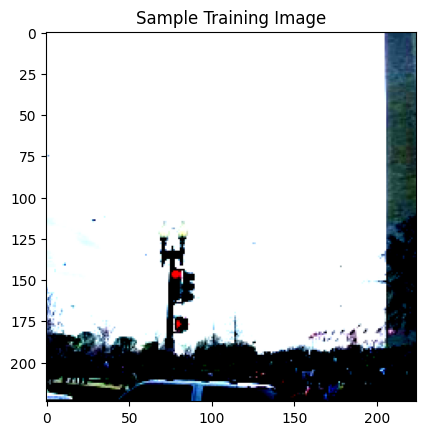

[0, 3749, 24, 187, 20, 1538, 262, 21, 166, 24, 21, 1720, 14, 21, 1720, 7, 306, 33, 678, 21, 122, 64, 24, 13, 3104, 463, 647, 14, 13, 7, 3, 681, 196, 33, 678, 1996, 60, 195, 14, 43, 20, 84, 85, 8, 21, 503, 33, 22, 10, 3, 929, 4212, 14, 43, 7, 3, 199, 30, 21, 263, 33, 10, 248, 335, 8, 13, 14, 31, 21, 53, 24, 4319, 2779, 7, 3, 169, 413, 10, 3, 174, 450, 14, 43, 20, 150, 262, 21, 1551, 24, 21, 1720, 967, 262, 13, 31, 3, 1677, 14, 1]
['<start>', 'crowds', 'of', 'people', 'are', 'gathered', 'around', 'the', 'bottom', 'of', 'the', 'monument', '.', 'the', 'monument', 'is', 'tall', ',', 'but', 'the', 'very', 'top', 'of', 'it', 'gets', 'cut', 'off', '.', 'it', 'is', 'a', 'cloud', 'day', ',', 'but', 'warm', 'and', 'sunny', '.', 'there', 'are', 'cars', 'parked', 'on', 'the', 'road', ',', 'along', 'with', 'a', 'police', 'care', '.', 'there', 'is', 'a', 'tree', 'to', 'the', 'right', ',', 'with', 'no', 'leaves', 'on', 'it', '.', 'in', 'the', 'center', 'of', 'teh', 'crows', 'is', 'a', 'street', 'lamp'

In [6]:
import matplotlib.pyplot as plt
import numpy as np
def show_image(img, title):
    """Display image with caption."""
    plt.imshow(img)
    plt.title(title)
    plt.pause(0.001)  # pause to update plots

# Get a batch of training data
images, captions = next(iter(data_loader))

# Convert images to numpy for visualization
images = images.numpy()

# Display the first image in the batch
show_image(np.transpose(images[0], (1, 2, 0)), "Sample Training Image");
captions =captions.tolist()
captions = captions[0]
print(captions)
print([data_loader.dataset.vocab.idx2word[x] for x in captions])


Vocabalary.py


In [7]:
print(data_loader.dataset.vocab("windows"))
print(data_loader.dataset.vocab("abadafd"))

sample_caption = 'A person doing a trick on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)




vocab = data_loader.dataset.vocab
start_word = vocab.start_word
end_word = vocab.end_word
sample_indices = [vocab(token) for token in sample_tokens]

# Add start and end indices
sample_indices = [vocab(start_word)] + sample_indices + [vocab(end_word)]

print("\nWord-Index Mapping:")
for word, idx in zip([start_word] + sample_tokens + [end_word], sample_indices):
    print(f"{word}:\t\t {idx}")

325
2
['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']

Word-Index Mapping:
<start>:		 0
a:		 3
person:		 285
doing:		 1023
a:		 3
trick:		 1024
on:		 8
a:		 3
rail:		 1803
while:		 697
riding:		 369
a:		 3
skateboard:		 80
.:		 14
<end>:		 1


In [8]:

print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 4592


In [9]:
vocab_threshold = 5

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         data_folder=data_folder)

[0/5715] Tokenizing captions... [                    ] 0.00%
[1000/5715] Tokenizing captions... [###                 ] 17.50%
[2000/5715] Tokenizing captions... [######              ] 35.00%
[3000/5715] Tokenizing captions... [##########          ] 52.49%
[4000/5715] Tokenizing captions... [#############       ] 69.99%
[5000/5715] Tokenizing captions... [#################   ] 87.49%
Obtaining caption lengths...


100%|██████████| 5715/5715 [00:03<00:00, 1466.48it/s]


In [10]:
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))
print("Word-Index Mapping:")
max_word_length = max(len(word) for word in vocab.word2idx.keys())
for word, idx in vocab.word2idx.items():
    print(f"{word:{max_word_length}} : {idx}")

Total number of tokens in vocabulary: 2553
Word-Index Mapping:
<start>         : 0
<end>           : 1
<unk>           : 2
a               : 3
white           : 4
round           : 5
plate           : 6
is              : 7
on              : 8
table           : 9
with            : 10
plastic         : 11
tablecloth      : 12
it              : 13
.               : 14
two             : 15
foil            : 16
covered         : 17
food            : 18
halves          : 19
are             : 20
the             : 21
along           : 22
serving         : 23
of              : 24
golden          : 25
yellow          : 26
french          : 27
fries           : 28
next            : 29
to              : 30
in              : 31
short           : 32
,               : 33
topless         : 34
container       : 35
sauce           : 36
diagonal        : 37
edges           : 38
several         : 39
other           : 40
stacked         : 41
plates          : 42
there           : 43
black           : 44
sh

In [11]:

data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True,
                         data_folder=data_folder)


Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 5715/5715 [00:03<00:00, 1677.20it/s]


In [12]:
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 2553


In [13]:
from collections import Counter
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)


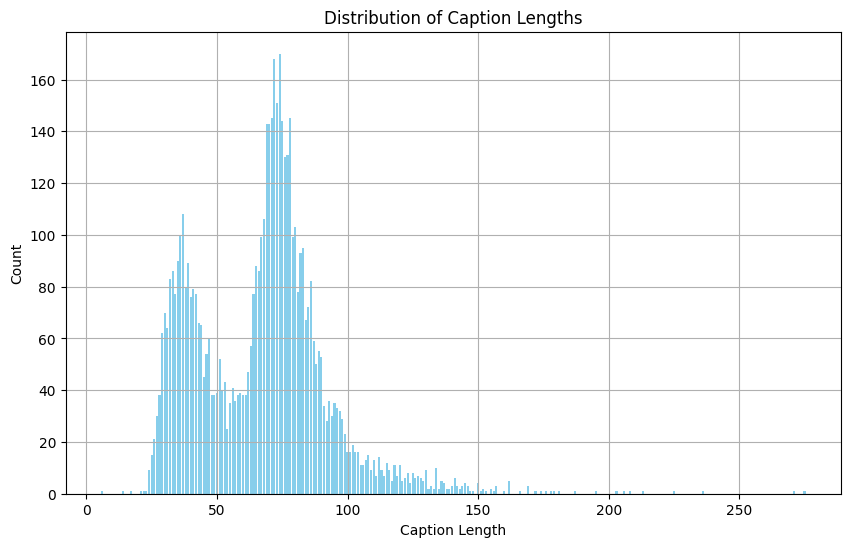

In [14]:
import matplotlib.pyplot as plt

# Assuming lengths is available as described in your code
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)

# Extracting lengths and their counts for plotting
x = [length for length, count in lengths]
y = [count for length, count in lengths]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='skyblue')
plt.xlabel('Caption Length')
plt.ylabel('Count')
plt.title('Distribution of Caption Lengths')
plt.grid(True)
plt.show()

In [15]:
!pip install tabulate


In [16]:
import torch.utils.data as data
from tabulate import tabulate
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler

images, captions = next(iter(data_loader))

table_data = [["images.shape", images.shape],
              ["captions.shape", captions.shape]]

print(tabulate(table_data, headers=["Variable", "Shape"]))

sampled indices: [3335, 5674, 3385, 246, 5476, 3270, 3445, 4454, 3440, 5160, 3601, 3144, 4918, 4522, 4012, 5691, 4254, 5503, 4173, 5463, 4751, 4440, 4160, 2957, 5408, 5424, 4188, 4262, 3932, 4463, 3181, 4873, 5272, 5035, 5068, 3163, 4081, 3139, 3821, 472, 4676, 3978, 2932, 5205, 5522, 4283, 5526, 3972, 3723, 4578, 3124, 1742, 5281, 4589, 2884, 5704, 3154, 5703, 3297, 3572, 4907, 4502, 4699, 4510]
Variable        Shape
--------------  -----------------------------
images.shape    torch.Size([64, 3, 224, 224])
captions.shape  torch.Size([64, 79])


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, drop_p=0.1):
        super(DecoderRNN, self).__init__()

        # Model attributes
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Embedding
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)

        # LSTM
        # batch_first=True:
        # in: (batch_size, caption_length, in_features/embedding_dim)
        # out: (batch_size, caption_length, out/hidden)
        self.lstm = nn.LSTM(self.embed_size,
                            self.hidden_size,
                            self.num_layers,
                            dropout=drop_p,
                            batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(drop_p)

        # Fully-connected output layer
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)

        # Softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        embed = self.embedding(captions)
        features = features.view(features.size(0), 1, -1)
        inputs = torch.cat((features, embed), dim=1)
        lstm_out, hidden = self.lstm(inputs)
        out = lstm_out.reshape(lstm_out.size(0)*lstm_out.size(1), lstm_out.size(2))
        # Pass through a dropout layer
        out = self.dropout(out)
        out = self.fc(out)
        out = out.view(lstm_out.size(0), lstm_out.size(1), -1)
        return out

    def sample(self, inputs, states=None, max_len=70):
        device = inputs.device  # Get the device from the input features
        outputs = []

        for i in range(max_len):
            with torch.no_grad():
                lstm_out, states = self.lstm(inputs, states)
                out = self.fc(lstm_out.squeeze(1))
                _, predicted = out.max(1)
                outputs.append(predicted.item())

                # Prepare the next input for the LSTM
                inputs = self.embedding(predicted)
                inputs = inputs.unsqueeze(1)
                inputs = inputs.to(device)  # Make sure to move the new input to the correct device

            # Assuming that end is at index 1
            if predicted.item() == 1:
                break

        return outputs

In [18]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="The parameter 'pretrained' is deprecated.*")
warnings.filterwarnings("ignore", message="Arguments other than a weight enum or `None`.*")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define embed_size
embed_size = 128

# Move encoder to the device
encoder = EncoderCNN(embed_size)
encoder.to(device)

# Move images to the device
images = images.to(device)

# Extract features using the encoder
features = encoder(images)

# Print information about the features
print("Feature Extraction Summary:")
print(f"Device: {device}")
print(f"Embedding Size: {embed_size}")
print(f"Type of Features: {type(features).__name__}")
print(f"Shape of Features: {features.shape}")


# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor."
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 45.8MB/s]


Feature Extraction Summary:
Device: cuda
Embedding Size: 128
Type of Features: Tensor
Shape of Features: torch.Size([64, 128])


In [19]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="The parameter 'pretrained' is deprecated.*")
warnings.filterwarnings("ignore", message="Arguments other than a weight enum or `None`.*")


# can tweek ##################################################
hidden_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)

# Move last batch of captions (from Step 1) to GPU if CUDA is available
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print("Decoder Output Summary:")
print(f"Type of Outputs: {type(outputs).__name__}")
print(f"Shape of Outputs: {outputs.shape}")

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Decoder Output Summary:
Type of Outputs: Tensor
Shape of Outputs: torch.Size([64, 79, 2553])


In [20]:
# Define the train hyper parameters
import math
save_every = 1
print_every = 100
log_file = 'training_log.txt'
# batch_size = 32
# vocab_threshold = 5        # minimum word count threshold
# vocab_from_file = False    # if True, load existing vocab file
# embed_size = 256          # dimensionality of image and word embeddings
# hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 30
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
params = list(encoder.embed.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
print("Training Hyperparameters:")
print(f"Save Every: {save_every}")
print(f"Print Every: {print_every}")
print(f"Log File: {log_file}")
print(f"Number of Epochs: {num_epochs}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Total Steps: {total_step}")

Training Hyperparameters:
Save Every: 1
Print Every: 100
Log File: training_log.txt
Number of Epochs: 30
CUDA Available: True
Total Steps: 90


In [22]:
# Train the model
# Save
torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-0.pkl'))
torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-0.pkl'))

In [23]:
decoder_file = 'decoder-0.pkl'
encoder_file = 'encoder-0.pkl'
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file),  map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file),  map_location='cpu'))

<All keys matched successfully>

In [24]:
import time

# Open the training log file.
log_file = 'training_log.txt'
f = open(log_file, 'w')

for epoch in range(1, num_epochs+1):

    for i_step in range(1, total_step+1):

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

        # Print training statistics.
        print(stats)

        # Log the statistics.
        f.write(stats + '\n')

    if epoch % save_every == 0:
      torch.save(decoder.state_dict(),os.path.join('./models', f'decoder-{epoch}.pkl'))
      torch.save(encoder.state_dict(),os.path.join('./models', f'encoder-{epoch}.pkl'))

# Close the training log file.
f.close()

Epoch [1/30], Step [1/90], Loss: 7.8491, Perplexity: 2563.3690
Epoch [1/30], Step [2/90], Loss: 7.8012, Perplexity: 2443.5404
Epoch [1/30], Step [3/90], Loss: 7.7521, Perplexity: 2326.4218
Epoch [1/30], Step [4/90], Loss: 7.6975, Perplexity: 2202.9238
Epoch [1/30], Step [5/90], Loss: 7.6314, Perplexity: 2061.9015
Epoch [1/30], Step [6/90], Loss: 7.5466, Perplexity: 1894.3189
Epoch [1/30], Step [7/90], Loss: 7.4295, Perplexity: 1684.9554
Epoch [1/30], Step [8/90], Loss: 7.2550, Perplexity: 1415.2003
Epoch [1/30], Step [9/90], Loss: 6.9782, Perplexity: 1072.9647
Epoch [1/30], Step [10/90], Loss: 6.5648, Perplexity: 709.6705
Epoch [1/30], Step [11/90], Loss: 6.1298, Perplexity: 459.3221
Epoch [1/30], Step [12/90], Loss: 5.7788, Perplexity: 323.3573
Epoch [1/30], Step [13/90], Loss: 5.5037, Perplexity: 245.6076
Epoch [1/30], Step [14/90], Loss: 5.2908, Perplexity: 198.4939
Epoch [1/30], Step [15/90], Loss: 5.1252, Perplexity: 168.2041
Epoch [1/30], Step [16/90], Loss: 5.0111, Perplexity: 1

In [25]:
transform_test = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [26]:
test_loader = get_loader(transform=transform_test,
                         mode='test',
                         batch_size=1,
                         data_folder=data_folder)

Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 928/928 [00:00<00:00, 1928.45it/s]


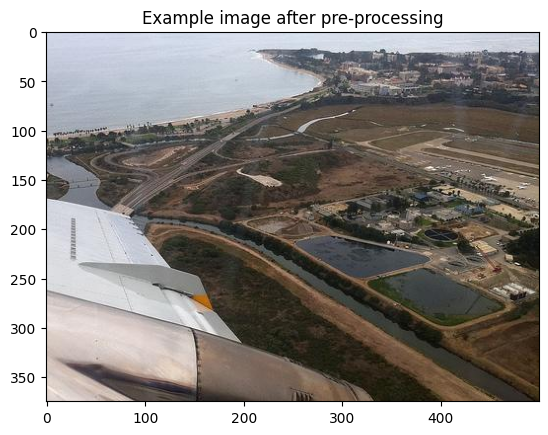

tensor([[   0,    2, 1313,  319,    3,  413,   24,    3,  468,  393,   14,   21,
          468,    7,  153,   10,  163,  248,   13,   14,   42,   20,  266, 2027,
            2,   59,    2,    2,   14,    1]])


In [27]:

orig_image,image, captions = next(iter(test_loader))
# Move to CPU since we're just displaying images



# Visualize sample image, after pre-processing.
# Note: The normalization does affect the visual output, and hence the images may look off-color.
# We need to reverse the normalization for displaying purposes.  # Get the first image in the batc

plt.imshow(np.squeeze(orig_image))
plt.title('Example image after pre-processing')
plt.show()
print(captions)

In [28]:
captions =captions.tolist()
captions = captions[0]
print(captions)
print([data_loader.dataset.vocab.idx2word[x] for x in captions])

[0, 2, 1313, 319, 3, 413, 24, 3, 468, 393, 14, 21, 468, 7, 153, 10, 163, 248, 13, 14, 42, 20, 266, 2027, 2, 59, 2, 2, 14, 1]
['<start>', '<unk>', 'view', 'from', 'a', 'plane', 'of', 'a', 'city', 'below', '.', 'the', 'city', 'is', 'lined', 'with', 'water', 'around', 'it', '.', 'there', 'are', 'many', 'winding', '<unk>', 'and', '<unk>', '<unk>', '.', '<end>']


In [29]:
caption_words = [data_loader.dataset.vocab.idx2word[token] for token in captions]
caption_string = ' '.join(caption_words)
print(caption_string)

<start> <unk> view from a plane of a city below . the city is lined with water around it . there are many winding <unk> and <unk> <unk> . <end>


In [30]:
individual_captions = caption_string.split('.')
individual_captions = [caption.strip() for caption in individual_captions if caption.strip()]
for i, caption in enumerate(individual_captions, start=1):
    print(f"Caption {i}: {caption}")

Caption 1: <start> <unk> view from a plane of a city below
Caption 2: the city is lined with water around it
Caption 3: there are many winding <unk> and <unk> <unk>
Caption 4: <end>


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
%load_ext autoreload
%autoreload 2

embed_size = 128
hidden_size = 256
#should be mathing from above value (up)
encoder_file = 'encoder-10.pkl'
decoder_file = 'decoder-10.pkl'
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()


encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file),  map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file),  map_location='cpu'))


# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


DecoderRNN(
  (embedding): Embedding(2553, 128)
  (lstm): LSTM(128, 256, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=2553, bias=True)
  (softmax): Softmax(dim=1)
)

In [33]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

image = image.to(device)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
image_cpu = image.cpu()

# Reverse the preprocessing steps
unnormalize = T.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
                          std=[1/s for s in [0.229, 0.224, 0.225]])

# Apply the unnormalize transform
image_cpu_unnorm = unnormalize(image_cpu.squeeze(0))  # Remove batch dim and unnormalize

# Display the image
# plt.figure(figsize=(10, 10))
# imshow(image_cpu_unnorm, title='Example Image')


# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)
features = features.to(device)
output = decoder.sample(features)
print('example output vocab ids:', output)
print('example output tokens:', [data_loader.dataset.vocab.idx2word[x] for x in output])

assert (type(output)==list), "Output needs to be a Python list"
assert all([type(x)==int for x in output]), "Output should be a list of integers."
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output vocab ids: [0, 119, 7, 91, 173, 24, 3, 610, 14, 21, 610, 7, 555, 138, 59, 97, 14, 21, 163, 7, 118, 2375, 14, 21, 163, 7, 2177, 14, 42, 7, 3, 141, 140, 21, 163, 14, 42, 7, 3, 157, 8, 21, 141, 14, 21, 157, 82, 20, 97, 59, 43, 14, 21, 141, 7, 103, 24, 562, 14, 42, 7, 3, 188, 31, 21, 485, 14, 21, 188, 31]
example output tokens: ['<start>', 'this', 'is', 'an', 'image', 'of', 'a', 'river', '.', 'the', 'river', 'is', 'dark', 'green', 'and', 'gray', '.', 'the', 'water', 'is', 'very', 'reflective', '.', 'the', 'water', 'is', 'moving', '.', 'there', 'is', 'a', 'bridge', 'over', 'the', 'water', '.', 'there', 'is', 'a', 'train', 'on', 'the', 'bridge', '.', 'the', 'train', 'cars', 'are', 'gray', 'and', 'black', '.', 'the', 'bridge', 'is', 'made', 'of', 'stone', '.', 'there', 'is', 'a', 'tree', 'in', 'the', 'foreground', '.', 'the', 'tree', 'in']


In [34]:
output = decoder.sample(features)
print('example output vocab ids:', output)
print('example output tokens:', [data_loader.dataset.vocab.idx2word[x] for x in output])

assert (type(output)==list), "Output needs to be a Python list"
assert all([type(x)==int for x in output]), "Output should be a list of integers."
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output vocab ids: [0, 119, 7, 91, 173, 24, 3, 610, 14, 21, 610, 7, 555, 138, 59, 97, 14, 21, 163, 7, 118, 2375, 14, 21, 163, 7, 2177, 14, 42, 7, 3, 141, 140, 21, 163, 14, 42, 7, 3, 157, 8, 21, 141, 14, 21, 157, 82, 20, 97, 59, 43, 14, 21, 141, 7, 103, 24, 562, 14, 42, 7, 3, 188, 31, 21, 485, 14, 21, 188, 31]
example output tokens: ['<start>', 'this', 'is', 'an', 'image', 'of', 'a', 'river', '.', 'the', 'river', 'is', 'dark', 'green', 'and', 'gray', '.', 'the', 'water', 'is', 'very', 'reflective', '.', 'the', 'water', 'is', 'moving', '.', 'there', 'is', 'a', 'bridge', 'over', 'the', 'water', '.', 'there', 'is', 'a', 'train', 'on', 'the', 'bridge', '.', 'the', 'train', 'cars', 'are', 'gray', 'and', 'black', '.', 'the', 'bridge', 'is', 'made', 'of', 'stone', '.', 'there', 'is', 'a', 'tree', 'in', 'the', 'foreground', '.', 'the', 'tree', 'in']


In [35]:
!pip install pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.5 MB/s eta 0:00:00


In [36]:
from pycocoevalcap.cider.cider import Cider

# # Initialize CIDEr scorer
# cider_scorer = Cider()

# reference_captions_list = []
# generated_captions_list = []
# i =0;
# for orig_image, image, captions in test_loader:
#     # Move image to device
#     image = image.to(device)
#     print(i)
#     i = i + 1
#     captions =captions.tolist()
#     captions = captions[0]
#     caption_words = [data_loader.dataset.vocab.idx2word[token] for token in captions]
#     caption_string = ' '.join(caption_words)
#     #print(caption_string)

#     reference_captions_list.append(caption_string)

#     features = encoder(image).unsqueeze(1)
#     features = features.to(device)
#     output = decoder.sample(features)

#     output_words = [data_loader.dataset.vocab.idx2word[token] for token in output]
#     output_string = ' '.join(output_words)
#     print("Caption:",caption_string)
#     print("Generated:",output_string)
#     generated_captions_list.append(output_string)
#     # Generate captions using the model
#     # with torch.no_grad():
#     #     features = encoder(image)
#     #     sampled_ids = decoder.sample(features)
#     #     generated_caption = [data_loader.dataset.vocab.idx2word[idx.item()] for idx in sampled_ids]


# # Compute CIDEr score
# cider_score, _ = cider_scorer.compute_score(reference_captions_list, generated_captions_list)
# print("CIDEr score:", cider_score)

# Initialize CIDEr scorer
cider_scorer = Cider()

reference_captions_dict = {}
generated_captions_dict = {}
i = 0
for orig_image, image, captions in test_loader:
    # Move image to device
    image = image.to(device)
    #print(i)
    i += 1

    #print(orig_image)
    # Convert captions tensor to list of tokens
    captions = captions.tolist()
    captions = captions[0]
    caption_words = [data_loader.dataset.vocab.idx2word[token] for token in captions]
    caption_string = ' '.join(caption_words)

    # Append reference captions to the dictionary
    reference_captions_dict[i] = [caption_string]

    # Generate captions using the model
    features = encoder(image).unsqueeze(1)
    features = features.to(device)
    output = decoder.sample(features)
    output_words = [data_loader.dataset.vocab.idx2word[token] for token in output]
    output_string = ' '.join(output_words)
    if(i<10):
        print("C:", caption_string)
        print("G:", output_string)
    # Append generated captions to the dictionary
    generated_captions_dict[i] = [output_string]

    # if i == 10:
    #     break

# Compute CIDEr score
cider_score, _ = cider_scorer.compute_score(reference_captions_dict, generated_captions_dict)
print("CIDEr score:", cider_score)


C: <start> i see a wooden table with broccoli , onions and carrots on top of it . there is also a sharp kitchen knife next to the carrots . the broccoli carrots and onions appears to be chopped . <end>
G: <start> the person is sitting on a bench looking at this cell phone . the cell phone is red . the person is wearing a helmet on their head . that helmet is a <unk> color . their bike is leaning up against the side of the bench with a person is sitting . the bike is blue and gray . there are people walking on the sidewalk in front
C: <start> there are several long boats in the water . there is a woman wearing a white hat . there are several bananas and fruits in the boat . there is a man on the dock . <end>
G: <start> this is an image of a river . the river is dark green and gray . the water is blue and green . there are <unk> on the room . the lights are in the <unk> are preparing to fly . in front of the boy is a clear and white checked bag is black writing . the boy is also wearing 

In [42]:
# # Import necessary libraries
# from pycocoevalcap.cider.cider import Cider
# from pycocoevalcap.spice.spice import Spice
# from pycocoevalcap.rouge.rouge import Rouge

# # Initialize CIDEr scorer
# cider_scorer = Cider()
# spice_scorer = Spice()
# rouge_scorer = Rouge()

# # Initialize dictionaries to store reference and generated captions for each model
# reference_captions_dict = {}
# generated_captions_dict = {}

# # Loop through each model
# cider_scores = []
# spice_scores = []
# rouge_l_scores = []

# for model_idx in range(1, 31):
#     print(f"Evaluating Model {model_idx}")

#     # Load encoder and decoder for the current model
#     encoder_file = f'encoder-{model_idx}.pkl'
#     decoder_file = f'decoder-{model_idx}.pkl'
#     encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file), map_location='cpu'))
#     decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file), map_location='cpu'))

#     # Move models to GPU if available
#     encoder.to(device)
#     decoder.to(device)

#     # Initialize index counter for the test_loader
#     i = 0

#     # Clear previous reference and generated captions
#     reference_captions_dict.clear()
#     generated_captions_dict.clear()

#     # Loop through the test_loader and generate captions for each image
#     for orig_image, image, captions in test_loader:
#         # Move image to device
#         image = image.to(device)

#         # Convert captions tensor to list of tokens
#         captions = captions.tolist()
#         captions = captions[0]
#         caption_words = [data_loader.dataset.vocab.idx2word[token] for token in captions]
#         caption_string = ' '.join(caption_words)

#         # Append reference captions to the dictionary
#         reference_captions_dict[i] = [caption_string]

#         # Generate captions using the model
#         features = encoder(image).unsqueeze(1)
#         features = features.to(device)
#         output = decoder.sample(features)
#         output_words = [data_loader.dataset.vocab.idx2word[token] for token in output]
#         output_string = ' '.join(output_words)

#         # Append generated captions to the dictionary
#         generated_captions_dict[i] = [output_string]

#         # Increment index counter
#         i += 1

#     # Compute CIDEr score for the current model
#     cider_score, _ = cider_scorer.compute_score(reference_captions_dict, generated_captions_dict)
#     print(f"CIDEr score for Model {model_idx}: {cider_score}")

#     # Store CIDEr score for current model
#     cider_scores.append(cider_score)

#     spice_score, _ = spice_scorer.compute_score(reference_captions_dict, generated_captions_dict)
#     print(f"SPICE score for Model {model_idx}: {spice_score}")
#     spice_scores.append(spice_score)

#     # Compute ROUGE-L score for the current model
#     rouge_l_score, _ = rouge_scorer.compute_score(reference_captions_dict, generated_captions_dict)
#     print(f"ROUGE-L score for Model {model_idx}: {rouge_l_score}")
#     rouge_l_scores.append(rouge_l_score)

# # Print CIDEr scores for all models
# print("CIDEr scores for all models:", cider_scores)

from tqdm import tqdm  # Import tqdm for progress bar

# Import necessary libraries
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge

# Initialize CIDEr scorer
cider_scorer = Cider()
bleu_scorer = Bleu()
rouge_scorer = Rouge()

# Initialize dictionaries to store reference and generated captions for each model
reference_captions_dict = {}
generated_captions_dict = {}

# Loop through each model
cider_scores = []
bleu_scores = []
rouge_l_scores = []

for model_idx in range(1, 31):
    print(f"Evaluating Model {model_idx}")

    # Load encoder and decoder for the current model
    encoder_file = f'encoder-{model_idx}.pkl'
    decoder_file = f'decoder-{model_idx}.pkl'
    encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file), map_location='cpu'))
    decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file), map_location='cpu'))

    # Move models to GPU if available
    encoder.to(device)
    decoder.to(device)

    # Initialize index counter for the test_loader
    i = 0

    # Clear previous reference and generated captions
    reference_captions_dict.clear()
    generated_captions_dict.clear()

    # Loop through the test_loader and generate captions for each image
    for orig_image, image, captions in tqdm(test_loader, desc=f"Model {model_idx}"):
        # Move image to device
        image = image.to(device)

        # Convert captions tensor to list of tokens
        captions = captions.tolist()
        captions = captions[0]
        caption_words = [data_loader.dataset.vocab.idx2word[token] for token in captions]
        caption_string = ' '.join(caption_words)

        # Append reference captions to the dictionary
        reference_captions_dict[i] = [caption_string]

        # Generate captions using the model
        features = encoder(image).unsqueeze(1)
        features = features.to(device)
        output = decoder.sample(features)
        output_words = [data_loader.dataset.vocab.idx2word[token] for token in output]
        output_string = ' '.join(output_words)

        # Append generated captions to the dictionary
        generated_captions_dict[i] = [output_string]

        # Increment index counter
        i += 1

    # Compute CIDEr score for the current model
    cider_score, _ = cider_scorer.compute_score(reference_captions_dict, generated_captions_dict)
    print(f"CIDEr score for Model {model_idx}: {cider_score}")
    cider_scores.append(cider_score)

    bleu_score, _ = bleu_scorer.compute_score(reference_captions_dict, generated_captions_dict)
    print(f"Bleu score for Model {model_idx}: {bleu_score}")
    bleu_scores.append(bleu_score)

    # Compute ROUGE-L score for the current model
    rouge_l_score, _ = rouge_scorer.compute_score(reference_captions_dict, generated_captions_dict)
    print(f"ROUGE-L score for Model {model_idx}: {rouge_l_score}")
    rouge_l_scores.append(rouge_l_score)
    # Store CIDEr score for current model

Evaluating Model 1


Model 1: 100%|██████████| 928/928 [00:48<00:00, 19.23it/s]


CIDEr score for Model 1: 0.008631946624185304
{'testlen': 64960, 'reflen': 64783, 'guess': [64960, 64032, 63104, 62176], 'correct': [20026, 3896, 420, 121]}
ratio: 1.0027321982618742
Bleu score for Model 1: [0.30828201970442876, 0.13695725356787197, 0.04997899199440272, 0.022201446310296562]
ROUGE-L score for Model 1: 0.29117959462371823
Evaluating Model 2


Model 2: 100%|██████████| 928/928 [00:45<00:00, 20.23it/s]


CIDEr score for Model 2: 0.012974050381876438
{'testlen': 64960, 'reflen': 64783, 'guess': [64960, 64032, 63104, 62176], 'correct': [19259, 4516, 564, 127]}
ratio: 1.0027321982618742
Bleu score for Model 2: [0.2964747536945767, 0.14460133137373152, 0.0571727303258196, 0.024856325934871977]
ROUGE-L score for Model 2: 0.24969654435803187
Evaluating Model 3


Model 3: 100%|██████████| 928/928 [00:45<00:00, 20.35it/s]


CIDEr score for Model 3: 0.02488663525922632
{'testlen': 64916, 'reflen': 64783, 'guess': [64916, 63988, 63060, 62132], 'correct': [22056, 4923, 930, 272]}
ratio: 1.0020530077334948
Bleu score for Model 3: [0.3397621541684586, 0.16167882734229153, 0.07277995137587165, 0.03604310636261957]
ROUGE-L score for Model 3: 0.2680967241764439
Evaluating Model 4


Model 4: 100%|██████████| 928/928 [00:42<00:00, 21.59it/s]


CIDEr score for Model 4: 0.035623984646175715
{'testlen': 59393, 'reflen': 64783, 'guess': [59393, 58465, 57537, 56609], 'correct': [21862, 5493, 1026, 336]}
ratio: 0.9167991602735145
Bleu score for Model 4: [0.3361567063528107, 0.16983269005679844, 0.0777338107838095, 0.039945485669723814]
ROUGE-L score for Model 4: 0.26408043536107245
Evaluating Model 5


Model 5: 100%|██████████| 928/928 [00:41<00:00, 22.37it/s]


CIDEr score for Model 5: 0.03766852292312395
{'testlen': 55357, 'reflen': 64783, 'guess': [55357, 54429, 53501, 52573], 'correct': [22315, 5983, 1276, 425]}
ratio: 0.8544988654430815
Bleu score for Model 5: [0.3399962844689775, 0.17754413168047617, 0.08591132458718224, 0.045599156623776615]
ROUGE-L score for Model 5: 0.27043670526406377
Evaluating Model 6


Model 6: 100%|██████████| 928/928 [00:41<00:00, 22.28it/s]


CIDEr score for Model 6: 0.03127364225895427
{'testlen': 57690, 'reflen': 64783, 'guess': [57690, 56762, 55834, 54906], 'correct': [23384, 5927, 1252, 377]}
ratio: 0.8905113995955592
Bleu score for Model 6: [0.35844427448085653, 0.18192866595341198, 0.08690346247054202, 0.04467957592740148]
ROUGE-L score for Model 6: 0.2695506940102509
Evaluating Model 7


Model 7: 100%|██████████| 928/928 [00:42<00:00, 21.88it/s]


CIDEr score for Model 7: 0.04365909891377324
{'testlen': 58656, 'reflen': 64783, 'guess': [58656, 57728, 56800, 55872], 'correct': [23578, 5872, 1219, 373]}
ratio: 0.9054227189231604
Bleu score for Model 7: [0.3621009314432228, 0.18215124736390226, 0.08624188962685271, 0.044317589634988566]
ROUGE-L score for Model 7: 0.2674201920992241
Evaluating Model 8


Model 8: 100%|██████████| 928/928 [00:44<00:00, 20.96it/s]


CIDEr score for Model 8: 0.04612261085517795
{'testlen': 60602, 'reflen': 64783, 'guess': [60602, 59674, 58746, 57818], 'correct': [24018, 5834, 1279, 362]}
ratio: 0.9354614636555743
Bleu score for Model 8: [0.3699026304222523, 0.18371859495553114, 0.0881885096965965, 0.044743480417709994]
ROUGE-L score for Model 8: 0.2650780710715535
Evaluating Model 9


Model 9: 100%|██████████| 928/928 [00:43<00:00, 21.53it/s]


CIDEr score for Model 9: 0.049379648347787
{'testlen': 60227, 'reflen': 64783, 'guess': [60227, 59299, 58371, 57443], 'correct': [23965, 5958, 1347, 396]}
ratio: 0.9296729080159776
Bleu score for Model 9: [0.3689207383832059, 0.18538156004922485, 0.09025753421173606, 0.0465600923828687]
ROUGE-L score for Model 9: 0.2650408401911009
Evaluating Model 10


Model 10: 100%|██████████| 928/928 [00:43<00:00, 21.20it/s]


CIDEr score for Model 10: 0.05993074282791721
{'testlen': 61214, 'reflen': 64783, 'guess': [61214, 60286, 59358, 58430], 'correct': [24208, 5979, 1398, 439]}
ratio: 0.9449083864593961
Bleu score for Model 10: [0.3730673097563659, 0.18682679421897644, 0.09187452211717713, 0.04841982765735551]
ROUGE-L score for Model 10: 0.2669089949757366
Evaluating Model 11


Model 11: 100%|██████████| 928/928 [00:47<00:00, 19.40it/s]


CIDEr score for Model 11: 0.0530088701267518
{'testlen': 60101, 'reflen': 64783, 'guess': [60101, 59173, 58245, 57317], 'correct': [23777, 5811, 1274, 395]}
ratio: 0.927727953321073
Bleu score for Model 11: [0.3659677912748823, 0.1823344909144599, 0.08762041660605606, 0.045506587858435234]
ROUGE-L score for Model 11: 0.2629873670673849
Evaluating Model 12


Model 12: 100%|██████████| 928/928 [00:44<00:00, 20.66it/s]


CIDEr score for Model 12: 0.05757554693110853
{'testlen': 60393, 'reflen': 64783, 'guess': [60393, 59465, 58537, 57609], 'correct': [23929, 5923, 1353, 396]}
ratio: 0.9322353086457723
Bleu score for Model 12: [0.36844175656708855, 0.18473110404574816, 0.09018329418003541, 0.046532191644054526]
ROUGE-L score for Model 12: 0.2650693712831244
Evaluating Model 13


Model 13: 100%|██████████| 928/928 [00:43<00:00, 21.45it/s]


CIDEr score for Model 13: 0.055174065609871294
{'testlen': 59525, 'reflen': 64783, 'guess': [59525, 58597, 57669, 56741], 'correct': [23692, 5830, 1275, 365]}
ratio: 0.9188367318586524
Bleu score for Model 13: [0.3643677616064989, 0.18217357082704663, 0.08757739919366431, 0.04459666766157271]
ROUGE-L score for Model 13: 0.2643065477244892
Evaluating Model 14


Model 14: 100%|██████████| 928/928 [00:45<00:00, 20.46it/s]


CIDEr score for Model 14: 0.04691178773013959
{'testlen': 59110, 'reflen': 64783, 'guess': [59110, 58182, 57254, 56326], 'correct': [23583, 5763, 1182, 335]}
ratio: 0.9124307302841654
Bleu score for Model 14: [0.3624576605893562, 0.18060019879492734, 0.08488984894289037, 0.042638860754485544]
ROUGE-L score for Model 14: 0.26551742093316105
Evaluating Model 15


Model 15: 100%|██████████| 928/928 [00:42<00:00, 21.62it/s]


CIDEr score for Model 15: 0.05388378797795865
{'testlen': 58264, 'reflen': 64783, 'guess': [58264, 57336, 56408, 55480], 'correct': [23372, 5885, 1280, 389]}
ratio: 0.8993717487612353
Bleu score for Model 15: [0.3586770225903627, 0.1814325913414572, 0.08741164301153488, 0.04523579670398104]
ROUGE-L score for Model 15: 0.2643907913323968
Evaluating Model 16


Model 16: 100%|██████████| 928/928 [00:42<00:00, 21.75it/s]


CIDEr score for Model 16: 0.047839043769723054
{'testlen': 58954, 'reflen': 64783, 'guess': [58954, 58026, 57098, 56170], 'correct': [23421, 5742, 1231, 347]}
ratio: 0.9100226911380932
Bleu score for Model 16: [0.3598751471613554, 0.17960815606366107, 0.08572674245427025, 0.0433319694470084]
ROUGE-L score for Model 16: 0.26227793400884153
Evaluating Model 17


Model 17: 100%|██████████| 928/928 [00:44<00:00, 20.75it/s]


CIDEr score for Model 17: 0.055047836775449326
{'testlen': 58629, 'reflen': 64783, 'guess': [58629, 57701, 56773, 55845], 'correct': [23498, 5893, 1235, 358]}
ratio: 0.9050059429171093
Bleu score for Model 17: [0.36085492788874246, 0.1821587278946879, 0.08661898764952575, 0.04400865213560477]
ROUGE-L score for Model 17: 0.26442931360385363
Evaluating Model 18


Model 18: 100%|██████████| 928/928 [01:04<00:00, 14.35it/s]


CIDEr score for Model 18: 0.056716730393136926
{'testlen': 64063, 'reflen': 64783, 'guess': [64063, 63135, 62207, 61279], 'correct': [24191, 5688, 1316, 389]}
ratio: 0.9888859731719589
Bleu score for Model 18: [0.3733924574657746, 0.18238409723129345, 0.08861417252588491, 0.04571583122674037]
ROUGE-L score for Model 18: 0.2585854914291819
Evaluating Model 19


Model 19: 100%|██████████| 928/928 [00:46<00:00, 19.79it/s]


CIDEr score for Model 19: 0.062255961027181235
{'testlen': 64774, 'reflen': 64783, 'guess': [64774, 63846, 62918, 61990], 'correct': [24412, 5680, 1299, 381]}
ratio: 0.9998610746646343
Bleu score for Model 19: [0.37682725042645093, 0.18308311811423122, 0.08844843778237525, 0.04541019575406634]
ROUGE-L score for Model 19: 0.2583939851132593
Evaluating Model 20


Model 20: 100%|██████████| 928/928 [01:00<00:00, 15.34it/s]


CIDEr score for Model 20: 0.05798415295524712
{'testlen': 64459, 'reflen': 64783, 'guess': [64459, 63531, 62603, 61675], 'correct': [24543, 5883, 1417, 433]}
ratio: 0.994998687927373
Bleu score for Model 20: [0.3788446196528947, 0.1868295898841588, 0.0922913549298124, 0.04840828658291791]
ROUGE-L score for Model 20: 0.26228272820821574
Evaluating Model 21


Model 21: 100%|██████████| 928/928 [00:59<00:00, 15.69it/s]


CIDEr score for Model 21: 0.06257258432359102
{'testlen': 64567, 'reflen': 64783, 'guess': [64567, 63639, 62711, 61783], 'correct': [24437, 5938, 1416, 441]}
ratio: 0.9966657919515769
Bleu score for Model 21: [0.37721105169376695, 0.18729414077709608, 0.09242121618450817, 0.04868082621739961]
ROUGE-L score for Model 21: 0.26123627599400207
Evaluating Model 22


Model 22: 100%|██████████| 928/928 [01:01<00:00, 14.99it/s]


CIDEr score for Model 22: 0.06454692392806939
{'testlen': 64445, 'reflen': 64783, 'guess': [64445, 63517, 62589, 61661], 'correct': [24527, 5922, 1433, 443]}
ratio: 0.9947825818501614
Bleu score for Model 22: [0.3785972220491132, 0.18738681700437654, 0.09282169370829732, 0.04889517019110835]
ROUGE-L score for Model 22: 0.26178779921004114
Evaluating Model 23


Model 23: 100%|██████████| 928/928 [00:45<00:00, 20.30it/s]


CIDEr score for Model 23: 0.06155788813087723
{'testlen': 64541, 'reflen': 64783, 'guess': [64541, 63613, 62685, 61757], 'correct': [24628, 5931, 1403, 413]}
ratio: 0.9962644520938982
Bleu score for Model 23: [0.38015879640744565, 0.18791408769098217, 0.09234104177905145, 0.04785804347658744]
ROUGE-L score for Model 23: 0.2614805390641242
Evaluating Model 24


Model 24: 100%|██████████| 928/928 [00:47<00:00, 19.72it/s]


CIDEr score for Model 24: 0.06475767562776363
{'testlen': 64436, 'reflen': 64783, 'guess': [64436, 63508, 62580, 61652], 'correct': [24509, 5972, 1432, 419]}
ratio: 0.9946436565148111
Bleu score for Model 24: [0.37831909435629346, 0.1881072062398454, 0.09303789076867894, 0.048303312672393996]
ROUGE-L score for Model 24: 0.2621783386508245
Evaluating Model 25


Model 25: 100%|██████████| 928/928 [00:44<00:00, 20.79it/s]


CIDEr score for Model 25: 0.0644784963273824
{'testlen': 64504, 'reflen': 64783, 'guess': [64504, 63576, 62648, 61720], 'correct': [24542, 5914, 1414, 433]}
ratio: 0.9956933146041247
Bleu score for Model 25: [0.37883041987768185, 0.18731702556744598, 0.09238598245928327, 0.048445165179083156]
ROUGE-L score for Model 25: 0.26123380156823456
Evaluating Model 26


Model 26: 100%|██████████| 928/928 [00:45<00:00, 20.60it/s]


CIDEr score for Model 26: 0.06739237534410619
{'testlen': 64491, 'reflen': 64783, 'guess': [64491, 63563, 62635, 61707], 'correct': [24598, 5913, 1386, 409]}
ratio: 0.9954926446752853
Bleu score for Model 26: [0.37969449735857685, 0.1875148671307372, 0.0918368670370874, 0.04754648518637144]
ROUGE-L score for Model 26: 0.2617285254997007
Evaluating Model 27


Model 27: 100%|██████████| 928/928 [00:50<00:00, 18.41it/s]


CIDEr score for Model 27: 0.06788609026030593
{'testlen': 64590, 'reflen': 64783, 'guess': [64590, 63662, 62734, 61806], 'correct': [24701, 6070, 1451, 431]}
ratio: 0.9970208233641389
Bleu score for Model 27: [0.3812866021421538, 0.19038429753685726, 0.09419828432405034, 0.04909864154466751]
ROUGE-L score for Model 27: 0.26316666455198523
Evaluating Model 28


Model 28: 100%|██████████| 928/928 [00:45<00:00, 20.55it/s]


CIDEr score for Model 28: 0.06243123862120334
{'testlen': 64247, 'reflen': 64783, 'guess': [64247, 63319, 62391, 61463], 'correct': [24509, 5878, 1355, 380]}
ratio: 0.9917262244724544
Bleu score for Model 28: [0.3783114673170724, 0.18662116817192406, 0.09085984138728141, 0.046309024547386175]
ROUGE-L score for Model 28: 0.2611312587212718
Evaluating Model 29


Model 29: 100%|██████████| 928/928 [00:44<00:00, 20.78it/s]


CIDEr score for Model 29: 0.06324862387062635
{'testlen': 64370, 'reflen': 64783, 'guess': [64370, 63442, 62514, 61586], 'correct': [24443, 5946, 1430, 420]}
ratio: 0.9936248707222421
Bleu score for Model 29: [0.3772980418162864, 0.18744465954737452, 0.09277681976768466, 0.04823083963699926]
ROUGE-L score for Model 29: 0.26198233784768177
Evaluating Model 30


Model 30: 100%|██████████| 928/928 [00:45<00:00, 20.52it/s]


CIDEr score for Model 30: 0.06939675875334088
{'testlen': 64495, 'reflen': 64783, 'guess': [64495, 63567, 62639, 61711], 'correct': [24599, 5950, 1436, 439]}
ratio: 0.9955543892687744
Bleu score for Model 30: [0.3797100392465065, 0.18810442064227512, 0.0931228160868006, 0.048902687650933495]
ROUGE-L score for Model 30: 0.2610013697895221


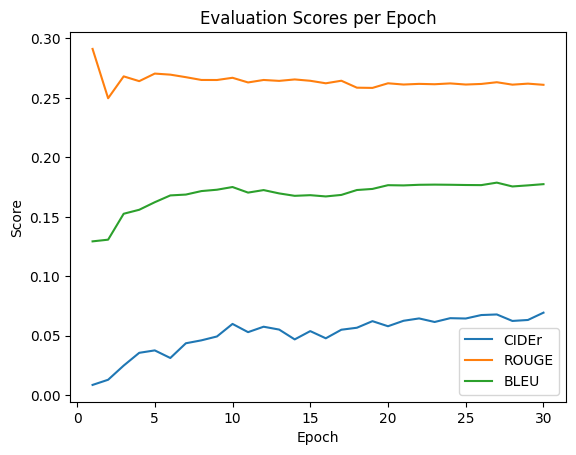

In [43]:
import matplotlib.pyplot as plt

bleu_score_array = []

# Iterate over the BLEU score vectors for each model
for bleu_scores_model in bleu_scores:
    # Convert the list of lists into a NumPy array for easier computation
    bleu_scores_model_array = np.array(bleu_scores_model)

    # Calculate the mean of the BLEU scores across all n-gram orders
    bleu_score_scalar = np.mean(bleu_scores_model_array)

    # Append the scalar BLEU score to the new list
    bleu_score_array.append(bleu_score_scalar)

# Print or use bleu_score_array as needed
# print("Scalar BLEU scores for each model:", bleu_score_array)
# Define the number of epochs
num_epochs = len(cider_scores)  # Assuming cider_scores, rouge_scores, and bleu_scores contain scores for each epoch

# Generate x-axis values (epochs)
epochs = list(range(1, num_epochs + 1))

# Plot CIDEr scores
plt.plot(epochs, cider_scores, label='CIDEr')

# Plot ROUGE scores
plt.plot(epochs, rouge_l_scores, label='ROUGE')

# Plot BLEU scores
plt.plot(epochs, bleu_score_array, label='BLEU')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Scores per Epoch')
plt.legend()

# Show plot
plt.show()

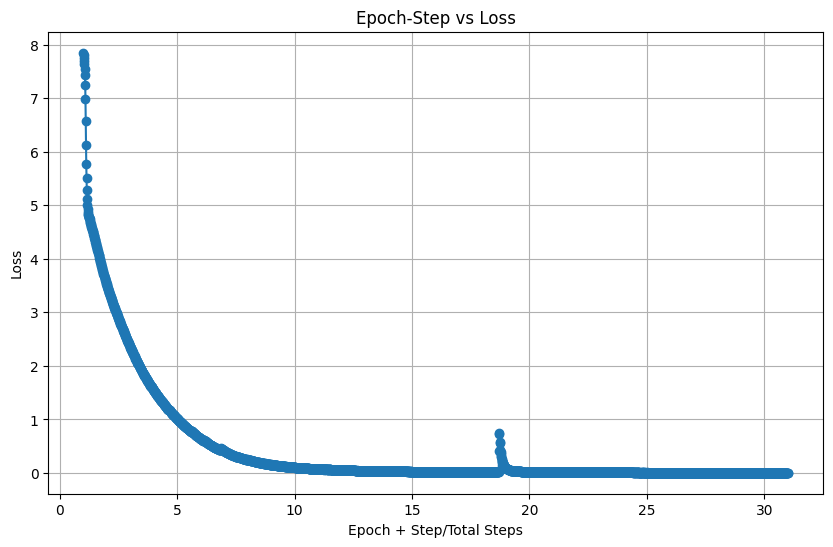

In [46]:
import matplotlib.pyplot as plt

# Read the training log file
with open('training_log.txt', 'r') as file:
    lines = file.readlines()

# Initialize lists to store combined epoch-step and loss values
epoch_steps = []
losses = []

# Total number of steps per epoch
total_steps_per_epoch = 90  # You can adjust this according to your training configuration

# Parse each line in the log file
for line in lines:
    # Extract epoch and step number from the line
    if line.startswith('Epoch'):
        epoch = int(line.split('[')[1].split('/')[0])
        step = int(line.split('Step [')[1].split('/')[0])
        loss = float(line.split('Loss: ')[1].split(',')[0])
        # Calculate combined epoch-step
        epoch_step = epoch + (step / total_steps_per_epoch)
        epoch_steps.append(epoch_step)
        losses.append(loss)

# Plot combined epoch-step versus loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_steps, losses, marker='o', linestyle='-')
plt.xlabel('Epoch + Step/Total Steps')
plt.ylabel('Loss')
plt.title('Epoch-Step vs Loss')
plt.grid(True)
plt.show()

In [45]:
model_idx=20
# Choosing the best model to take outputs
print(f"Evaluating Model {model_idx}")

# Load encoder and decoder for the current model
encoder_file = f'encoder-{model_idx}.pkl'
decoder_file = f'decoder-{model_idx}.pkl'
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file), map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file), map_location='cpu'))

# Move models to GPU if available
encoder.to(device)
decoder.to(device)

# Initialize index counter for the test_loader
i = 0

# Clear previous reference and generated captions
reference_captions_dict.clear()
generated_captions_dict.clear()

# Loop through the test_loader and generate captions for each image
for orig_image, image, captions in test_loader:
  # Move image to device
        image = image.to(device)

        # Convert captions tensor to list of tokens
        captions = captions.tolist()
        captions = captions[0]
        caption_words = [data_loader.dataset.vocab.idx2word[token] for token in captions]
        caption_string = ' '.join(caption_words)

        # Append reference captions to the dictionary
        reference_captions_dict[i] = [caption_string]

        # Generate captions using the model
        features = encoder(image).unsqueeze(1)
        features = features.to(device)
        output = decoder.sample(features)
        output_words = [data_loader.dataset.vocab.idx2word[token] for token in output]
        output_string = ' '.join(output_words)

        print("C:", caption_string)
        print("G:", output_string)
        # Append generated captions to the dictionary
        generated_captions_dict[i] = [output_string]

        print()
        # Increment index counter
        i += 1


Evaluating Model 20
C: <start> a white refrigerator is against a wall in a kitchen . someone has positioned two magnets to appear as eyes on the refrigerator so the <unk> appears to have a face . there are two white handles in between the magnets to appear as if they are the nose on the refrigerator . the refrigerator has a bottom drawer for the <unk> and the handle is curved upwards . the refrigerator appears to have eyes , a nose , and a smiling mouth . <end>
G: <start> a little boy is standing above the ramp . the boy is wearing a helmet . the helmet is white . the boy is carrying a skateboard . the skateboard is olive green in color . the boy is wearing a long sleeve shirt . the shirt is light red . the boy is also wearing a jeans . on the ramp few feet away from the boy is

C: <start> an elephant <unk> in the water . a man lays on the back of the elephant . a few other men stand around the elephant and look at it . the water is a brown color . the men are all wearing swim trunks .